# Minority Game

In [1]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm

In [2]:
class History:
    def __init__(self, M: int):
        self.M = M
        self.history = np.random.randint(0, 2 ** M)
    
    def __repr__(self):
        return f'{self.history:0{self.M}b}'
    
    def update(self, new_bit):
        self.history = (np.left_shift(self.history, 1) + new_bit) % (2 ** self.M)

In [3]:
class Agents:
    def __init__(self, N: int, S: int, M: int, gammas: np.ndarray, beta: int):
        assert N % 2 == 1
        self.N, self.S, self.M, self.beta = N, S, M, beta
        assert gammas.shape == (N,)
        self.gammas = gammas.reshape(-1, 1)
        self.strategies = np.random.randint(0, 2, (N, S, 2 ** M))
        self.utilities = np.zeros((N, S))
    
    def update_utility(self, s: np.ndarray, a: np.ndarray, attendance: int):
        """
        s: index of chosen strategy
        a: chosen action
        attendance: sum of all agents actions
        """
        assert s.shape == a.shape == (self.N,)
        self.utilities[np.arange(self.N), s] -= a * attendance / self.beta
    
    def choose_strategy(self):
        return torch.distributions.Categorical(logits=torch.from_numpy(self.utilities * self.gammas)).sample().numpy()
    
    def get_action(self, s: np.ndarray, history: History):
        """Get action from history for a given strategy.
        +1 if strategy says 1
        -1 if strategy says 0
        """
        assert s.shape == (self.N,)
        assert np.all(0 <= s) and np.all(s < self.S)
        h = history.history
        strategy = self.strategies[np.arange(self.N), s]
        return 2 * strategy[:, h] - 1
    

In [4]:
class MinorityGame:
    def __init__(self, N: int, M: int, S: int, initial_price: int, history_mode: str):
        """
        N: #agents
        M: #bits in history
        S: #strategy per agent
        """
        assert N % 2 == 1
        self.N, self.M, self.S = N, M, S
        self.agents = Agents(N, S, M, gammas=np.ones(N) / 100, beta=1)
        self.history = History(M)
        self.price = initial_price
        assert history_mode in ['random', 'sign']
        self.history_mode = history_mode
        
    @property
    def alpha(self):
        return (2 ** self.M) / self.N
    
    @property
    def lambda_(self):
        return self.N * 100
    
    def step(self) -> int:
        strategies = self.agents.choose_strategy()
        actions = self.agents.get_action(strategies, self.history)
        attendance = actions.sum()
        
        self.price *= np.exp(attendance / self.lambda_)
        self.agents.update_utility(strategies, actions, attendance)
        
        new_bit = np.random.randint(0, 2) if self.history_mode == 'random' else (1 + np.sign(attendance)) // 2
        self.history.update(new_bit)
        
        return attendance
    

## Compute and save

In [ ]:
Ns = [51, 101, 251, 501, 1001]
Ms = list(range(19))
T = 10000
variances = OrderedDict()
for N in Ns:
    variances[N] = OrderedDict()
    for M in Ms:
        game = MinorityGame(N, M, S=2, initial_price=100, history_mode='sign')
        attendances = [game.step() for t in range(T)]
        v = np.var(attendances) / N
        variances[N][M] = v
torch.save(variances, 'results.pt')

## Load directly

Should look like Figure 3 of this [paper](https://arxiv.org/pdf/cond-mat/0402651.pdf)

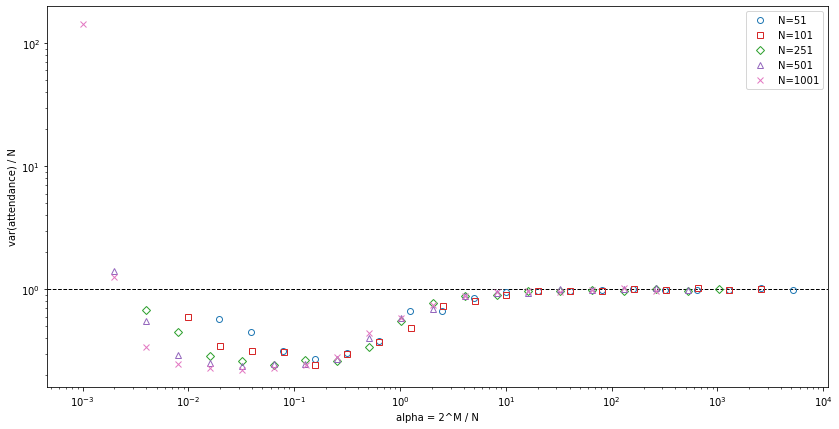

In [5]:
variances = torch.load('results.pt')
fig, ax = plt.subplots(figsize=(14, 7))
ax.axhline(y=1, color='black', linestyle='--', linewidth=1)
colors = {51: 'tab:blue', 101: 'tab:red', 251: 'tab:green', 501: 'tab:purple', 1001: 'tab:pink'}
markers = {51: 'o', 101: 's', 251: 'D', 501: '^', 1001: 'x'}

for N, d in variances.items():
    alphas = [2 ** M / N for M in d]
    ax.loglog(alphas, list(d.values()), color=colors[N], marker=markers[N], linestyle='', fillstyle='none', label=f'N={N}')

ax.legend()
ax.set(xlabel='alpha = 2^M / N', ylabel='var(attendance) / N')
plt.show()

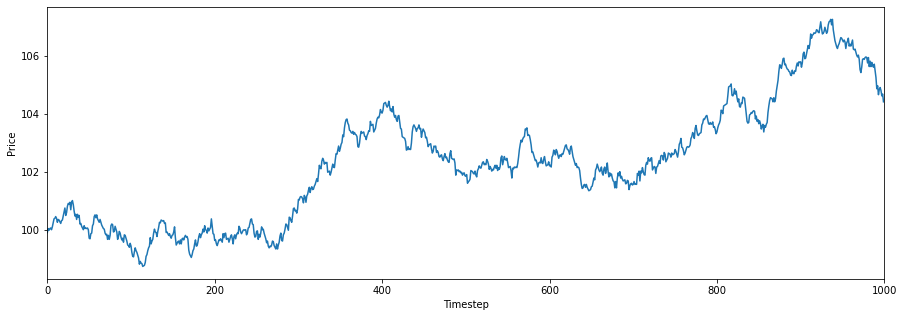

In [7]:
game = MinorityGame(N=51, M=15, S=2, initial_price=100, history_mode='sign')
prices = []
for t in range(1000):
    game.step()
    prices.append(game.price)
    
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(prices)
ax.set_xlabel('Timestep')
ax.set_ylabel('Price')
ax.set_xlim(0, len(prices))
plt.show()